## 0. Setting Inputs


In [1]:
target_date = "20230623"
base_rate = 3.50 # BOK base rate on target_date
cd_rate = 3.75 # 91-day CD rate on target_date
rate_change_expectation = 0.25  # To calculate the amount of 'reflection' in the market

## 1. Scrape IRS data


In [2]:
import asyncio
from pyppeteer import launch
from bs4 import BeautifulSoup

from pprint import pprint
import pandas as pd

import nest_asyncio # to avoid jupyter notebook error
nest_asyncio.apply()

In [3]:
# IRS table getter, returns df
def _get_IRS_table(irs_table) -> pd.DataFrame:
    """
    Extracts data from an IRS table and returns it as a DataFrame.
    
    Args:
        irs_table: BeautifulSoup object representing the IRS table.
        
    Returns:
        DataFrame containing the extracted data from the IRS table.
    """
    
    data_list = list()
    
    for tr in irs_table.find_all("tr"):
        # get all table rows and initialize a dictionary
        data = {}

        for th, td in zip(irs_table.select('th'), tr.select("td")):
            # match each tr data with column heads
            data[th.text.strip()] = td.text.strip()
        
        data_list.append(data) # moved out of the loop for incremental indexing

    # Set as df and drop duplicate rows
    df = pd.DataFrame(data_list)
    df = df.drop_duplicates()
    
    return df

In [4]:
async def main(target_date):
    """
    Main function to crawl the IRS data for a given target date from SMBS website.
    
    Args:
        target_date: The target date in the format 'YYYYMMDD'.
        
    Returns:
        The HTML content of the crawled data.
    """
    
    browser = await launch(headless=True, autoClose=False)
    page = await browser.newPage()
    await page.goto('http://www.smbs.biz/Exchange/IRS.jsp')

    await page.waitFor(2000)

    await page.evaluate(f"""() => {{
        document.getElementById('searchDate').value = '';
    }}""")

    elements = await page.xpath("//input[contains(@id, 'searchDate')]")
    await elements[0].click()

    await page.waitFor(1000)
    await page.type("#searchDate", target_date) 

    await page.waitFor(1000)
    elements = await page.xpath("//img[contains(@alt, '조회하기')]")
    await elements[0].click()
    
    # Wait for the browser to navigate
    await page.waitForNavigation()
    
    html = await page.content()
    await browser.close()
    
    return html

In [5]:
async def _crawl_IRS_tables(target_dates):
    """
    Crawls IRS tables for a list of target dates and returns a list of dataframes.
    
    Args:
        target_dates: A list of target dates in the format 'YYYYMMDD'.
        
    Returns:
        A list of dataframes containing the crawled IRS data for each target date.
    """
    
    html_responses = []

    for target_date in target_dates:
        html_response = await main(target_date)
        html_responses.append(html_response)

    data_list = []

    for html_response, target_date in zip(html_responses, target_dates):
        soup = BeautifulSoup(html_response, "html.parser")

        # Isolate IRS table from other data
        irs_table = soup.find_all("div", attrs={"class" : "table_type2"})[0]

        # Retrieve date data
        search_date = soup.find("input", attrs={"name" : "StrSchFull3"})
        date = search_date.get("value")

        df = _get_IRS_table(irs_table)
        df = df.iloc[1:].reset_index(drop=True)  # drop first row (null)

        data_list.append(df)

    return data_list

In [6]:
# Run for 1 target date 
target_dates =[target_date]
result = asyncio.run(_crawl_IRS_tables(target_dates))
print(result)

[     기일물 Receive     Mid     Pay
0     6M  3.8100  3.8050  3.8000
1     9M  3.8225  3.8175  3.8125
2     1Y  3.8100  3.8050  3.8000
3   1.5Y  3.7525  3.7475  3.7425
4     2Y  3.6850  3.6800  3.6750
5     3Y  3.5800  3.5750  3.5700
6     4Y  3.5125  3.5075  3.5025
7     5Y  3.4650  3.4600  3.4550
8     6Y  3.4350  3.4300  3.4250
9     7Y  3.4100  3.4050  3.4000
10    8Y  3.4000  3.3950  3.3900
11    9Y  3.3950  3.3900  3.3850
12   10Y  3.3900  3.3850  3.3800
13   12Y  3.3975  3.3925  3.3875
14   15Y  3.3925  3.3875  3.3825
15   20Y  3.3375  3.3325  3.3275]


## 2. Forward rate & market reflection table

1. IRS 'Mid' 데이터 추출
2. Linear interpolation을 통해 3개월 단위 swap rate 계산
3. tenor별 discount factor / zero rate / implied forward rate 도출

In [7]:
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [8]:
def _convert_crawled_to_df(df, cd_rate):
    """
    Converts the crawled data DataFrame to the desired format.
    1) Set 'tenor' column in year terms. (ex. 6M = 0.5)
    2) Set 'tenor' as index, coverted to float type.
    3) Fill in empty spots using current cd_rate and linear interpolation.

    Args:
        df: DataFrame containing the crawled data.
        cd_rate: Constant rate for filling empty spots.

    Returns:
        A new DataFrame with the converted data.
    """
        
    # Convert columns to float data type
    df.iloc[:, 1:4] = df.iloc[:, 1:4].astype(float)

    # Adjust the string tenors to float values
    def convert_tenor(tenor):
        if tenor == '6M':
            return 0.5
        elif tenor == '9M':
            return 0.75
        else:
            return float(tenor[:-1])
    
    df['tenor'] = df['기일물'].apply(convert_tenor)

    # Create a new DataFrame with desired index
    new_df = pd.DataFrame(index=np.arange(0.25, 2.25, 0.25))
    new_df = new_df.merge(df[['tenor', 'Mid']], how='left', left_index=True, right_on='tenor')
    new_df.set_index('tenor', inplace=True)
    new_df.columns = ['swap_rate']

    # Convert index to float data type
    new_df.index = new_df.index.astype(float)

    # Fill in empty spots 
    new_df['swap_rate'].fillna(cd_rate, limit=1, inplace=True)
    new_df['swap_rate'] = new_df['swap_rate'].interpolate(method='linear')
    new_df['swap_rate'] = new_df['swap_rate']/100

    return new_df

In [9]:
def discount_factor(swap_rate, df_list, payment_frequency=4):
    """
    Calculates the discount factor for each index 'i' in df, based on the data of indexes 1 to 'i-1'.
    
    Args:
        spot: The spot rate in decimal form.
        df_list : A list of discount factors, where df_list[i] is the discount factor for the i-th tenor.
        payment_frequency: The frequency of payments within each year. Default is 4.(quarterly payments)
        
    Returns:
        The discount factor for the given spot rate and tenor.  
    """
    
    accumulated_cash_flows = 0
    for i in range(len(df_list)):
        accumulated_cash_flows += (swap_rate / payment_frequency) * df_list[i-1]
    df_t = (1 - accumulated_cash_flows) / (1 + (swap_rate / payment_frequency))
    
    return df_t

In [10]:
def calculate_discount_factor(df):
    
    # Create empty column
    df['discount_factor'] = np.nan

    # Calculate discount factor
    for index, row in df.iterrows():
        swap_rate = row['swap_rate']
        tenor = index
        df_list = df[df.index < tenor]['discount_factor'].tolist()

        df_t = discount_factor(swap_rate, df_list)
        df.loc[index, 'discount_factor'] = df_t

In [11]:
def calculate_zero_rate(df):
    
    # Create empty column
    df['zero_rate'] = np.nan

    # Calculate zero rate
    df['zero_rate'] = -np.log(df['discount_factor']) / df.index

In [12]:
def calculate_implied_forward(df):
    
    # Create empty column
    df['implied_forward'] = np.nan

    # Calculate implied forward rate
    for i in range(len(df)-1):
        zero_rate_current = df.at[df.index[i], 'zero_rate']
        zero_rate_future = df.at[df.index[i+1], 'zero_rate']
        tenor_current = df.index[i]
        tenor_future = df.index[i+1]

        implied_forward = (((1 + zero_rate_future) ** tenor_future) / 
                           ((1 + zero_rate_current) ** tenor_current)) ** (1 / (tenor_future - tenor_current)) - 1
        df.at[df.index[i], 'implied_forward'] = implied_forward

    df['implied_forward'].iloc[-1] = np.nan

In [13]:
def calculate_market_reflection(df, base_rate, rate_change_expectation):
    """
    Calculates the market reflection for each tenor in the DataFrame.

    Args:
        df: DataFrame containing the swap rates.
        base_rate: Base rate used in the market reflection calculation.
        rate_change_expectation: Expected rate change used in the market reflection calculation.

    Returns:
        DataFrame: The original DataFrame with discount factors, zero rates, implied forwards, 
                and market reflection column added.
    """
    
    # Check if columns already exist
    if 'discount_factor' not in df.columns:
        df['discount_factor'] = np.nan
    if 'zero_rate' not in df.columns:
        df['zero_rate'] = np.nan
    if 'implied_forward' not in df.columns:
        df['implied_forward'] = np.nan
    
    # Calculate discount factor, zero rate, and implied forward
    calculate_discount_factor(df)
    calculate_zero_rate(df)
    calculate_implied_forward(df)
    
    # Calculate market reflection
    df['reflection'] = (df['implied_forward'] - (base_rate + rate_change_expectation) / 100) \
                           / (rate_change_expectation / 100)
    
    return df

In [14]:
# Calculate market reflection for each crawled data
for i in range(len(result)):
    new_df = _convert_crawled_to_df(result[i], cd_rate)
    new_df = calculate_market_reflection(new_df, base_rate, rate_change_expectation)

new_df

,swap_rate,discount_factor,zero_rate,implied_forward,reflection
tenor,,,,,
0.25,0.037500,0.990712,0.037325,0.038420,0.368196
0.50,0.038050,0.981242,0.037873,0.038245,0.298097
0.75,0.038175,0.971905,0.037997,0.037492,-0.003338
1.00,0.038050,0.962838,0.037871,0.036420,-0.432072
1.25,0.037763,0.954111,0.037580,0.035837,-0.665066
1.50,0.037475,0.945601,0.037290,0.034897,-1.041333
1.75,0.037138,0.937388,0.036947,0.034208,-1.316959
2.00,0.036800,0.929407,0.036605,NaN,NaN


## 3. Visualize market reflection

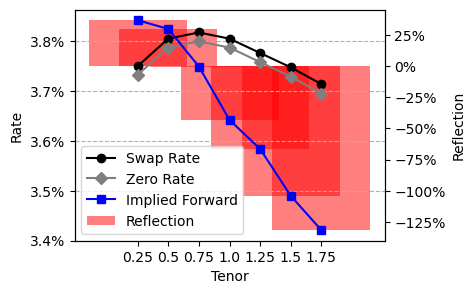

In [15]:
# Visualize using Matplotlib
fig, ax = plt.subplots(figsize=(4, 3))
new_df = new_df.dropna(subset=['implied_forward', 'reflection'])
x = np.arange(0.25, 2, 0.25)

# Draw line charts for swap rate, zero rate, and implied forward
ax.plot(x, new_df['swap_rate']*100, color='black', marker='o', label='Swap Rate')
ax.plot(x, new_df['zero_rate']*100, color='tab:gray', marker='D', label='Zero Rate')
ax.plot(x, new_df['implied_forward']*100, color='blue', marker='s', label='Implied Forward')

# Draw bar chart for reflection
ax2 = ax.twinx()
ax2.bar(x, new_df['reflection']*100, color='red', alpha=0.5, label='Reflection')

# Set z order to put line charts in front
ax.set_zorder(ax2.get_zorder() + 1)
ax.patch.set_visible(False)

# Set the y axes to % format 
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=1))
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
 
# Set axis lables
ax.set_xlabel('Tenor')
ax.set_ylabel('Rate')
ax2.set_ylabel('Reflection')

# Set ticks and hline
ax.set_xticks(x)
ax.set_xticklabels(x)
ax.grid(axis='y', linestyle='--')

# Add a legend for both the line charts and the bar chart
lines, labels = ax.get_legend_handles_labels()
bars, bar_labels = ax2.get_legend_handles_labels()
ax.legend(lines + bars, labels + bar_labels)

# Show the plot
plt.show()

## 4. Search for a range of dates

In [16]:
from pandas import to_datetime

In [17]:
# Convert the search date to pandas datetime format
search_date_dt = to_datetime(target_date,format="%Y%m%d")
print(search_date_dt)

2023-06-23 00:00:00


In [18]:
# Define the date range
start_date = search_date_dt - pd.DateOffset(weeks=4)
date_range = pd.date_range(start=start_date, end=search_date_dt, freq='W', inclusive='both').tolist()
date_range.append(search_date_dt)

date_range

[Timestamp('2023-05-28 00:00:00', freq='W-SUN'),
 Timestamp('2023-06-04 00:00:00', freq='W-SUN'),
 Timestamp('2023-06-11 00:00:00', freq='W-SUN'),
 Timestamp('2023-06-18 00:00:00', freq='W-SUN'),
 Timestamp('2023-06-23 00:00:00')]

In [19]:
# Iterate over each target date
target_dates = []
for date in date_range:
    target_date = date.strftime('%Y%m%d')
    target_dates.append(target_date)

target_dates

['20230528', '20230604', '20230611', '20230618', '20230623']

In [20]:
# Run the code through target dates 
result = asyncio.run(_crawl_IRS_tables(target_dates))

# Calculate market reflection for each crawled data
dfs=[]
for i in range(len(result)):
    new_df = _convert_crawled_to_df(result[i], cd_rate)
    new_df = calculate_market_reflection(new_df, base_rate, rate_change_expectation)
    new_df = pd.DataFrame(new_df)
    dfs.append(new_df)

In [21]:
# Extract reflection columns 
reflection_table = pd.DataFrame()
for i in range(len(dfs)):
    reflection_table[target_dates[i]] = dfs[i]['reflection']
reflection_table = reflection_table.dropna()

reflection_table

,20230528,20230604,20230611,20230618,20230623
tenor,,,,,
0.25,0.348279,0.089396,0.228785,0.368196,0.368196
0.50,0.108159,-0.080618,0.048723,0.328109,0.298097
0.75,-0.715041,-0.943800,-0.654079,-0.113953,-0.003338
1.00,-0.861302,-1.331720,-0.991759,-0.552677,-0.432072
1.25,-1.175097,-1.766560,-1.345937,-0.826112,-0.665066
1.50,-1.419017,-2.202885,-1.772460,-1.171772,-1.041333
1.75,-1.714839,-2.640582,-2.149487,-1.467715,-1.316959
